# 2018 NCAA March Madness Men's Basketball Predictions

### By Brice Walker

[View on GitHub](https://github.com/bricewalker/NCAA-2018-Mens-March-Madness)

[View on nbviewer](http://nbviewer.jupyter.org/github/bricewalker/NCAA-2018-Mens-March-Madness/blob/master/Madness.ipynb)

## Outline

- [Introduction](#intro)
- [Importing libraries](#libraries)
- [Importing the dataset](#data)
- [Exploratory analysis and plotting](#analysis)
- [Feature extraction and engineering](#features)
- [Classification analysis](#classification)
    - [Logistic Regression](#log-reg)
    - [KNeighbors](#knn)
    - [Random Forest](#forest)
    - [Extra Trees](#extra)
    - [Support Vector Machine](#svm)
    - [Gradient Boosting](#gradboost)
    - [XGBoost](#xgboost)
    - [LightGBM](#lgbm)
    - [Keras/Tensorflow Neural Network](#nn)
    - [Principle Component Analysis](#pca)
- [Ensembling Our Classification models](#ensemble-class)
- [Stacking](#stacking)
- [Exporting the final model](#exporting)
- [Building The Bracket](#bracket)

<a id='intro'></a>
## Introduction

This is a classification project completed for the 2018 March Madness Kaggle Competition. In this project, I have extracted 18 season-based, and 28 tournament-based team-level characteristics from several datasets using data from 1994-2017. I used datasets provided by kaggle, as well as data scraped from sports-reference.com. I then engineered several advanced measures and extracted Elo ratings. I used these characteristics to predict probabilities for each matchup in the 2018 March Madness Schedule. I then created a well calibrated soft voting classifier that used KNeighbors, Random Forest, Extra Trees, Logistic Regression, Gradient Boosting, and LightGBM classifiers as well as a Keras/TensorFlow Neural Network to predict probabilities for each matchup. Finally, I developed predictions based on Microsoft's TrueSkill rating system and weighted them with the machine learning model predictions.

### The Bracket
![bracket](output.png)

<a id='libraries'></a>
## Importing libraries

In [1]:
# Common imports
import pandas as pd
import numpy as np
import scipy as sp
import collections
import os
import sys
import math
from math import pi
from math import sqrt
import csv
import urllib
import pickle
import random
import statsmodels.api as sm
from patsy import dmatrices

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

# Math and descriptive stats
from math import sqrt
from scipy import stats
from scipy.stats import norm, skew
from scipy.stats.stats import pearsonr
from scipy.special import boxcox1p, inv_boxcox1p

# Sci-kit Learn modules for machine learning
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, log_loss
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, AdaBoostClassifier, AdaBoostRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor, VotingClassifier
from sklearn.ensemble import IsolationForest, RandomForestClassifier, RandomForestRegressor, RandomTreesEmbedding
from sklearn.svm import SVR, LinearSVC, SVC, LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import PCA, KernelPCA

# Boosting libraries
import lightgbm as lgb
import xgboost

# Deep Learning modules
from keras.layers import Input, Dense, Dropout, Flatten, Embedding, merge, Activation
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.optimizers import SGD
from keras.utils import np_utils, to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf

from trueskill import TrueSkill, Rating, rate_1vs1

K = 20.
HOME_ADVANTAGE = 100.

C:\Users\brice\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\brice\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<a id='data'></a>
## Importing The Data Sets

### Stage 1

In [2]:
# Kaggle provided data
reg_season_compact_pd = pd.read_csv('Data/KaggleData/RegularSeasonCompactResults.csv')
seasons_pd = pd.read_csv('Data/KaggleData/Seasons.csv')
teams_pd = pd.read_csv('Data/KaggleData/Teams.csv')
tourney_compact_pd = pd.read_csv('Data/KaggleData/NCAATourneyCompactResults.csv')
tourney_detailed_pd = pd.read_csv('Data/KaggleData/NCAATourneyDetailedResults.csv')
conference_pd = pd.read_csv('Data/KaggleData/Conference.csv')
tourney_results_pd = pd.read_csv('Data/KaggleData/TourneyResults.csv')
sample_sub_pd = pd.read_csv('Data/KaggleData/sample_submission.csv')
tourney_seeds_pd = pd.read_csv('Data/KaggleData/NCAATourneySeeds.csv')
team_conferences_pd = pd.read_csv('Data/KaggleData/TeamConferences.csv')
sample_sub_pd = pd.read_csv('Data/KaggleData/SampleSubmissionStage1.csv')
seeds_pd = pd.read_csv('Data/KaggleData/NCAATourneySeeds.csv')
# Data I created
elos_ratings_pd = pd.read_csv('Data/Ratings/season_elos.csv')
enriched_pd = pd.read_csv('Data/KaggleData/NCAATourneyDetailedResultsEnriched.csv')

### Stage 2

In [3]:
# You'll want to comment out this code if you want to run the first stage analysis
tourney_seeds_pd = pd.read_csv('Data/KaggleData/NCAATourneySeeds_SampleTourney2018.csv')
seasons_pd = pd.read_csv('Data/KaggleData/Seasons_SampleTourney2018.csv')
slots_pd = pd.read_csv('Data/KaggleData/NCAATourneySlots_SampleTourney2018.csv')
sample_sub_pd = pd.read_csv('Data/KaggleData/SampleSubmissionStage2_SampleTourney2018.csv')
reg_season_compact_pd = pd.read_csv('Data/KaggleData/RegularSeasonCompactResults_Prelim2018.csv')
reg_season_detailed_pd = pd.read_csv('Data/KaggleData/RegularSeasonDetailedResults_Prelim2018.csv')
enriched_pd2018 = pd.read_csv('Data/KaggleData/NCAATourneyDetailedResultsEnriched2018.csv')

<a id='analysis'></a>
## Exploratory analysis and plotting

### Season Data

In [4]:
pd.pivot_table(reg_season_compact_pd,index=['Season']).tail(10)

,DayNum,LScore,LTeamID,NumOT,WScore,WTeamID
Season,,,,,,
2009,70.963612,61.980377,1281.312250,0.071633,74.033721,1287.680511
2010,70.741212,62.484325,1279.997910,0.063272,74.652480,1289.607638
2011,70.881243,62.470644,1283.078727,0.077964,74.374190,1285.244758
2012,70.745479,61.415953,1283.055778,0.070055,73.379973,1286.596802
2013,68.058647,60.908083,1285.594361,0.072744,72.840789,1284.684211
2014,68.882507,64.452070,1280.580940,0.082991,76.101268,1288.116561
2015,70.742249,61.007845,1279.929399,0.079380,72.680799,1288.073963
2016,70.922332,66.327063,1279.221270,0.078413,78.295958,1289.136711
2017,70.796849,66.615199,1280.339203,0.075626,78.645783,1288.622428


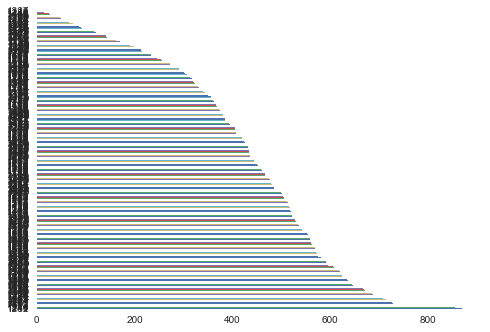

In [5]:
reg_season_compact_pd['WTeamID'].value_counts().plot(kind='barh')

#### This is a pretty large spread, some teams win a lot.

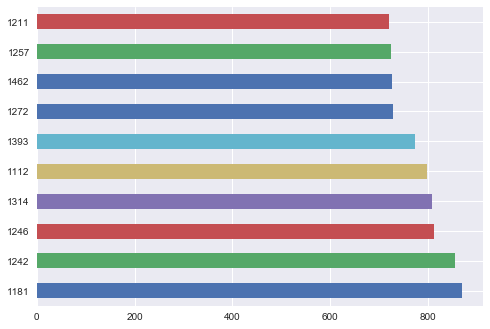

In [6]:
reg_season_compact_pd['WTeamID'].value_counts()[:10].plot(kind='barh')

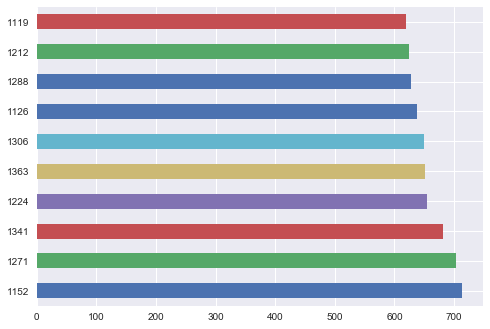

In [7]:
reg_season_compact_pd['LTeamID'].value_counts()[:10].plot(kind='barh')

#### Let's plot the winning score against the losing score.

C:\Users\brice\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


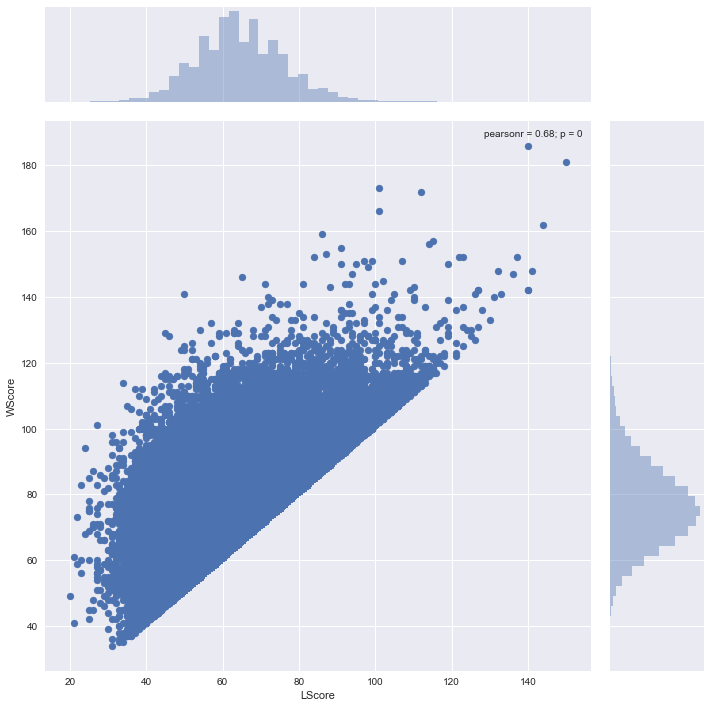

In [8]:
sns.jointplot(x='LScore', y='WScore', data=reg_season_compact_pd, size=10)

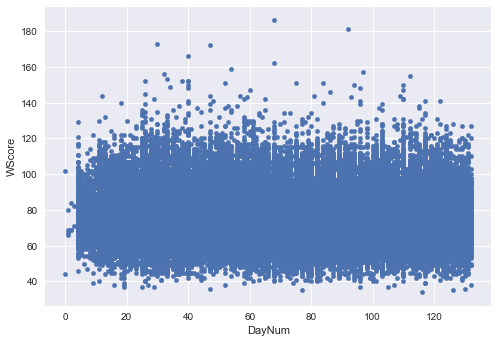

In [9]:
reg_season_compact_pd.plot(kind="scatter", x='DayNum', y='WScore')

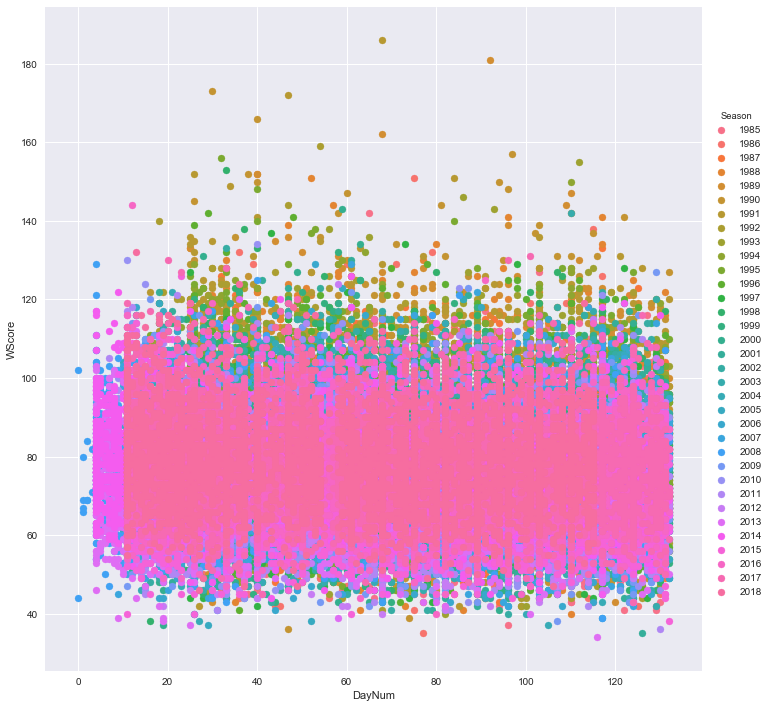

In [10]:
with sns.color_palette("PuBuGn_d"):
    sns.FacetGrid(reg_season_compact_pd, hue="Season", size=10) \
       .map(plt.scatter, 'DayNum', 'WScore') \
       .add_legend()

#### This is pretty noisy, there doesn't appear to be much of a relationship between day of the year and winning. It doesn't look like teams slow down further into the season.

C:\Users\brice\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


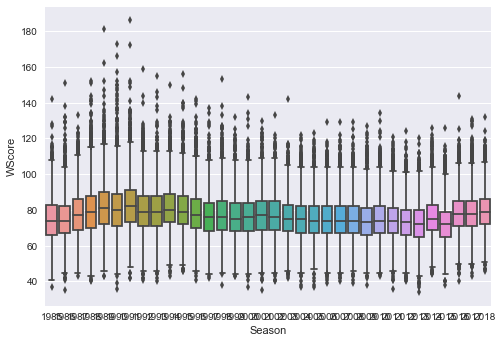

In [11]:
sns.boxplot(x='Season', y='WScore', data=reg_season_compact_pd)

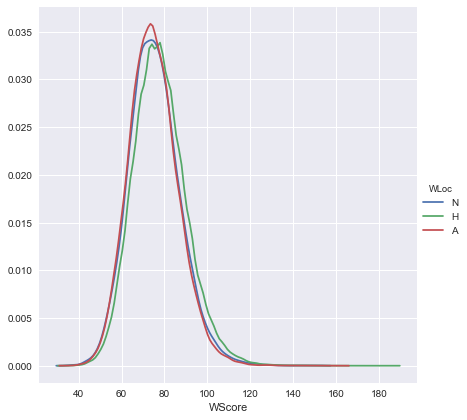

In [12]:
sns.FacetGrid(reg_season_compact_pd, hue='WLoc', size=6) \
   .map(sns.kdeplot, 'WScore') \
   .add_legend()

#### Plotting score with location doesn't show much of a home field advantage, but extensive research has been done on this so we will continue with this assumption.

C:\Users\brice\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


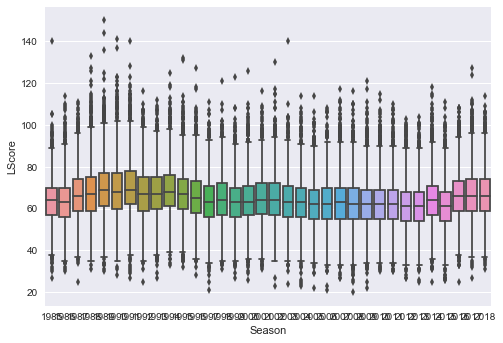

In [13]:
sns.boxplot(x='Season', y='LScore', data=reg_season_compact_pd)

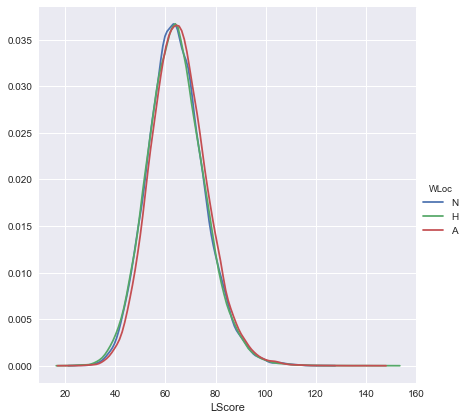

In [14]:
sns.FacetGrid(reg_season_compact_pd, hue='WLoc', size=6) \
   .map(sns.kdeplot, 'LScore') \
   .add_legend()

### Tournament Data

In [15]:
pd.pivot_table(tourney_detailed_pd,index=['Season']).tail(5)

,DayNum,LAst,LBlk,LDR,LFGA,LFGA3,LFGM,LFGM3,LFTA,LFTM,...,WFGM,WFGM3,WFTA,WFTM,WOR,WPF,WScore,WStl,WTO,WTeamID
Season,,,,,,,,,,,,,,,,,,,,,
2013,138.955224,10.537313,3.194030,21.552239,55.671642,19.373134,21.238806,5.313433,16.522388,11.552239,...,24.970149,6.701493,21.611940,15.567164,10.074627,15.656716,72.208955,7.000000,11.313433,1275.164179
2014,138.955224,10.582090,2.791045,20.492537,55.671642,17.985075,22.343284,5.462687,18.149254,12.776119,...,25.791045,6.194030,21.507463,16.074627,9.388060,16.492537,73.850746,5.791045,10.223881,1278.014925
2015,138.955224,10.507463,2.776119,21.567164,56.955224,18.940299,22.686567,6.223881,15.283582,11.029851,...,25.253731,6.343284,22.089552,16.074627,9.537313,15.716418,72.925373,6.044776,9.865672,1296.656716
2016,138.955224,11.179104,2.820896,22.104478,58.253731,20.746269,23.791045,6.522388,16.477612,11.253731,...,27.522388,7.179104,21.208955,16.119403,9.492537,16.611940,78.343284,6.358209,10.895522,1325.597015
2017,138.955224,12.179104,2.940299,21.597015,59.208955,22.328358,24.686567,7.059701,16.164179,12.119403,...,27.940299,7.238806,22.656716,16.313433,10.522388,16.358209,79.432836,5.910448,10.731343,1299.582090


In [16]:
tourney_detailed_pd.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

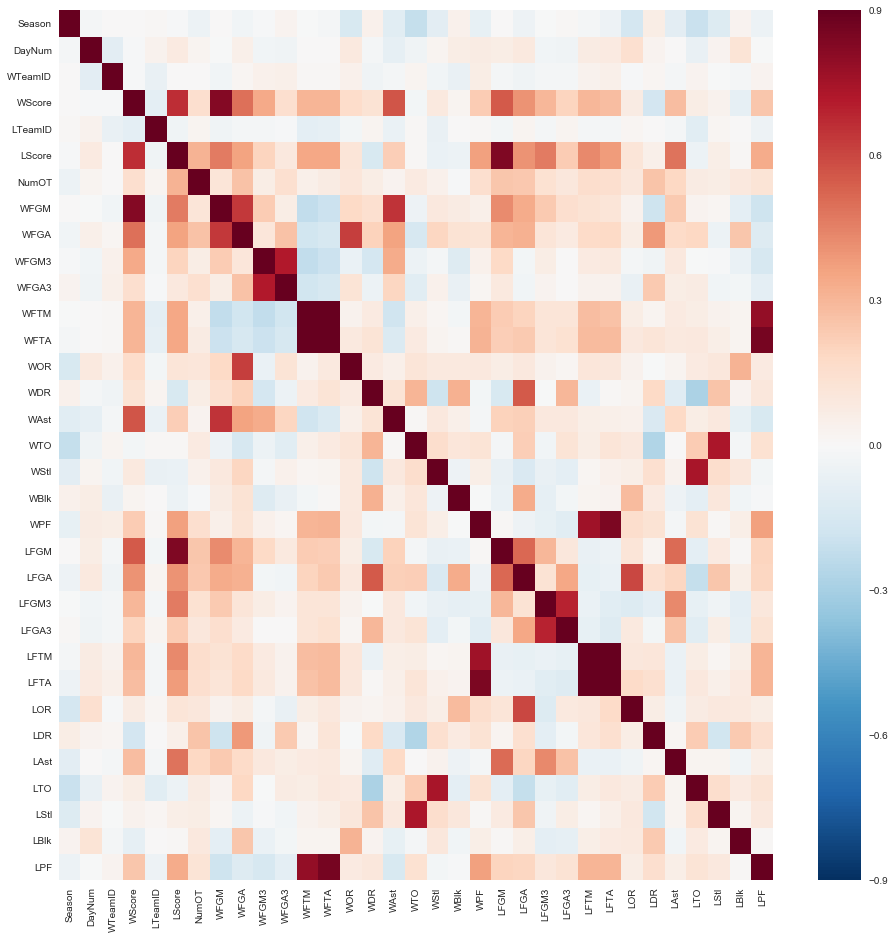

In [17]:
initial_heatmap = tourney_detailed_pd.corr()
plt.subplots(figsize=(16,16))
sns.heatmap(initial_heatmap, vmax=0.9, square=False)

C:\Users\brice\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


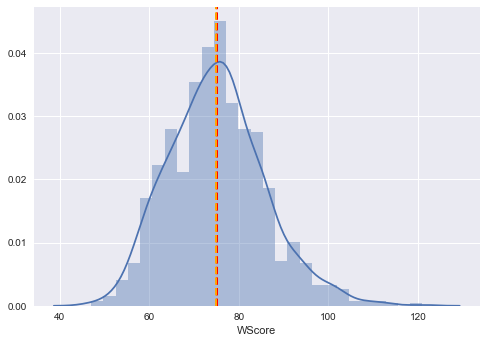

In [18]:
sns.distplot(tourney_detailed_pd['WScore']);
plt.axvline(tourney_detailed_pd['WScore'].mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(tourney_detailed_pd['WScore'].median(), color='orange', linestyle='dashed', linewidth=2)

<a id='features'></a>
## Feature Engineering and Extraction

This project attempts to predict outcomes of games based on the following team level characteristics for season games:
- A modified Elo rating (where new entrants are initialized at a score of 1500, and there is no reversion to the mean between seasons)
- Number of wins
- Avg points per game scored
- Avg points per game allowed
- Avg # of 3 pointers per game
- Avg turnovers per game
- Avg Assists per game
- Avg rebounds per game
- Avg steals per game
- Power 6 Conference
- Reg Season championships
- Strength of team's schedule
- Championship appearances
- Location of the game
- A simple rating system

And the following team level characteristics for tournament performance:<br>
> Note: If a team plays in more than one tourney in a year than these values are averaged over all tourneys they played that year.

- Tournament appearances
- Conference tournament championships
- Points scored for winning/losing team
- A measure of possession
- Offensive efficiency
- Defensive efficiency
- Net Rating (Offensive - Defensive efficiency)
- Assist Ratio
- Turnover Ratio
- Shooting Percentage
- Effective Field Goal Percentage adjusting for the fact that 3pt shots are more valuable
- FTA Rating : How good a team is at drawing fouls.
- Percentage of team offensive rebounds
- Percentage of team defensive rebounds
- Percentage of team total rebounds

Finally, predictions using these features are weighted and stacked with predictions made through team trueskill ratings.

### Advanced Tournament Characteristics

In [19]:
def createTourneyFeats(): 
    # Advanced tournament data
    df = pd.read_csv('Data/KaggleData/RegularSeasonDetailedResults_Prelim2018.csv')
    # Points Winning/Losing Team
    df['WPts'] = df.apply(lambda row: 2*row.WFGM + row.WFGM3 + row.WFTM, axis=1)
    df['LPts'] = df.apply(lambda row: 2*row.LFGM + row.LFGM3 + row.LFTM, axis=1)
    # Calculate Winning/losing Team Possesion Feature
    wPos = df.apply(lambda row: 0.96*(row.WFGA + row.WTO + 0.44*row.WFTA - row.WOR), axis=1)
    df['WPos'] = df.apply(lambda row: 0.96*(row.WFGA + row.WTO + 0.44*row.WFTA - row.WOR), axis=1)
    lPos = df.apply(lambda row: 0.96*(row.LFGA + row.LTO + 0.44*row.LFTA - row.LOR), axis=1)
    df['LPos'] = lPos = df.apply(lambda row: 0.96*(row.LFGA + row.LTO + 0.44*row.LFTA - row.LOR), axis=1)
    df['Pos'] = (wPos+lPos)/2
    # Offensive efficiency (OffRtg) = 100 x (Points / Possessions)
    df['WOffRtg'] = df.apply(lambda row: 100 * (row.WPts / row.Pos), axis=1)
    df['LOffRtg'] = df.apply(lambda row: 100 * (row.LPts / row.Pos), axis=1)
    # Defensive efficiency (DefRtg) = 100 x (Opponent points / Opponent possessions)
    df['WDefRtg'] = df.LOffRtg
    df['LDefRtg'] = df.WOffRtg
    # Net Rating = Off.Rtg - Def.Rtg
    df['WNetRtg'] = df.apply(lambda row:(row.WOffRtg - row.WDefRtg), axis=1)
    df['LNetRtg'] = df.apply(lambda row:(row.LOffRtg - row.LDefRtg), axis=1)                       
    # Assist Ratio : Percentage of team possessions that end in assists
    df['WAstR'] = df.apply(lambda row: 100 * row.WAst / (row.WFGA + 0.44*row.WFTA + row.WAst + row.WTO), axis=1)
    df['LAstR'] = df.apply(lambda row: 100 * row.LAst / (row.LFGA + 0.44*row.LFTA + row.LAst + row.LTO), axis=1)
    # Turnover Ratio: Number of turnovers of a team per 100 possessions used.
    # (TO * 100) / (FGA + (FTA * 0.44) + AST + TO
    df['WTOR'] = df.apply(lambda row: 100 * row.LAst / (row.LFGA + 0.44*row.LFTA + row.LAst + row.LTO), axis=1)
    df['LTOR'] = df.apply(lambda row: 100 * row.LAst / (row.LFGA + 0.44*row.LFTA + row.LAst + row.LTO), axis=1)                  
    # The Shooting Percentage : Measure of Shooting Efficiency (FGA/FGA3, FTA)
    df['WTSP'] = df.apply(lambda row: 100 * row.WPts / (2 * (row.WFGA + 0.44 * row.WFTA)), axis=1)
    df['LTSP'] = df.apply(lambda row: 100 * row.LPts / (2 * (row.LFGA + 0.44 * row.LFTA)), axis=1)
    # eFG% : Effective Field Goal Percentage adjusting for the fact that 3pt shots are more valuable 
    df['WeFGP'] = df.apply(lambda row:(row.WFGM + 0.5 * row.WFGM3) / row.WFGA, axis=1)      
    df['LeFGP'] = df.apply(lambda row:(row.LFGM + 0.5 * row.LFGM3) / row.LFGA, axis=1)   
    # FTA Rate : How good a team is at drawing fouls.
    df['WFTAR'] = df.apply(lambda row: row.WFTA / row.WFGA, axis=1)
    df['LFTAR'] = df.apply(lambda row: row.LFTA / row.LFGA, axis=1)                       
    # OREB% : Percentage of team offensive rebounds
    df['WORP'] = df.apply(lambda row: row.WOR / (row.WOR + row.LDR), axis=1)
    df['LORP'] = df.apply(lambda row: row.LOR / (row.LOR + row.WDR), axis=1)
    # DREB% : Percentage of team defensive rebounds
    df['WDRP'] = df.apply(lambda row: row.WDR / (row.WDR + row.LOR), axis=1)
    df['LDRP'] = df.apply(lambda row: row.LDR / (row.LDR + row.WOR), axis=1)                                      
    # REB% : Percentage of team total rebounds
    df['WRP'] = df.apply(lambda row: (row.WDR + row.WOR) / (row.WDR + row.WOR + row.LDR + row.LOR), axis=1)
    df['LRP'] = df.apply(lambda row: (row.LDR + row.WOR) / (row.WDR + row.WOR + row.LDR + row.LOR), axis=1) 
    df['WPIE'] = df.apply(lambda row: (row.WDR + row.WOR) / (row.WDR + row.WOR + row.LDR + row.LOR), axis=1)
    wtmp = df.apply(lambda row: row.WPts + row.WFGM + row.WFTM - row.WFGA - row.WFTA + row.WDR + 0.5*row.WOR + row.WAst +row.WStl + 0.5*row.WBlk - row.WPF - row.WTO, axis=1)
    ltmp = df.apply(lambda row: row.LPts + row.LFGM + row.LFTM - row.LFGA - row.LFTA + row.LDR + 0.5*row.LOR + row.LAst +row.LStl + 0.5*row.LBlk - row.LPF - row.LTO, axis=1) 
    df['WPIE'] = wtmp/(wtmp + ltmp)
    df['LPIE'] = ltmp/(wtmp + ltmp)

    df.to_csv('Data/KaggleData/NCAATourneyDetailedResultsEnriched2018.csv', index=False)

### Advanced Season Characteristics

In [20]:
def createEloRating():
    # Creating custom Elo ratings. This takes a long time to run so beware!
    team_ids = set(reg_season_compact_pd.WTeamID).union(set(reg_season_compact_pd.LTeamID))

    elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

    reg_season_compact_pd['margin'] = reg_season_compact_pd.WScore - reg_season_compact_pd.LScore
    reg_season_compact_pd['w_elo'] = None
    reg_season_compact_pd['l_elo'] = None

    def elo_pred(elo1, elo2):
        return(1. / (10. ** (-(elo1 - elo2) / 400.) + 1.))

    def expected_margin(elo_diff):
        return((7.5 + 0.006 * elo_diff))

    def elo_update(w_elo, l_elo, margin):
        elo_diff = w_elo - l_elo
        pred = elo_pred(w_elo, l_elo)
        mult = ((margin + 3.) ** 0.8) / expected_margin(elo_diff)
        update = K * mult * (1 - pred)
        return(pred, update)

    assert np.all(reg_season_compact_pd.index.values == np.array(range(reg_season_compact_pd.shape[0]))), "Index is out of order."

    preds = []

    # Loop over all rows
    for i in range(reg_season_compact_pd.shape[0]):

        # Get key data from each row
        w = reg_season_compact_pd.at[i, 'WTeamID']
        l = reg_season_compact_pd.at[i, 'LTeamID']
        margin = reg_season_compact_pd.at[i, 'margin']
        wloc = reg_season_compact_pd.at[i, 'WLoc']

        # Home court advantage?
        w_ad, l_ad, = 0., 0.
        if wloc == "H":
            w_ad += HOME_ADVANTAGE
        elif wloc == "A":
            l_ad += HOME_ADVANTAGE

        # Get elo updates as a result of each game
        pred, update = elo_update(elo_dict[w] + w_ad,
                                  elo_dict[l] + l_ad, 
                                  margin)
        elo_dict[w] += update
        elo_dict[l] -= update
        preds.append(pred)

        # Store elos in new dataframe
        reg_season_compact_pd.loc[i, 'w_elo'] = elo_dict[w]
        reg_season_compact_pd.loc[i, 'l_elo'] = elo_dict[l]

### Regular Season Characteristics

In [21]:
def seed_to_int(seed):
# Convert seeds to integers
    s_int = int(seed[1:3])
    return s_int
seeds_pd['seed_int'] = seeds_pd.Seed.apply(seed_to_int)
seeds_pd.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label
seeds_pd.head(2)

,Season,TeamID,seed_int
0,1985,1207,1
1,1985,1210,2


In [22]:
teamList = teams_pd['TeamName'].tolist()
NCAAChampionsList = tourney_results_pd['NCAA Champion'].tolist()

In [23]:
def Power6Conf(team_id):
    team_pd = team_conferences_pd[(team_conferences_pd['Season'] == 2018) & (team_conferences_pd['TeamID'] == team_id)]
    if (len(team_pd) == 0):
        return 0
    confName = team_pd.iloc[0]['ConfAbbrev']
    return int(confName == 'sec' or confName == 'acc'or confName == 'big_ten' or confName == 'big_twelve' or confName == 'big_east' or confName == 'pac_twelve')

In [24]:
def createTeamName(team_id):
    return teams_pd[teams_pd['TeamID'] == team_id].values[0][1]

def findNumChampionships(team_id):
    name = createTeamName(team_id)
    return NCAAChampionsList.count(name)

In [25]:
def handleCases(arr):
    indices = []
    listLen = len(arr)
    for i in range(listLen):
        if (arr[i] == 'St' or arr[i] == 'FL'):
            indices.append(i)
    for p in indices:
        arr[p-1] = arr[p-1] + ' ' + arr[p]
    for i in range(len(indices)): 
        arr.remove(arr[indices[i] - i])
    return arr

In [49]:
def checkConferenceChamp(team_id, year):  
    if year in conference_pd.Year:                            
        year_conf_pd = conference_pd[conference_pd['Year'] == year]
        champs = year_conf_pd['Regular Season Champ'].tolist()
    # In case of a tie
        champs_separated = [words for segments in champs for words in segments.split()]
        name = createTeamName(team_id)
        champs_separated = handleCases(champs_separated)
        if (name in champs_separated):
            return 1
        else:
            return 0
    else:
            return 0

In [50]:
def checkConferenceTourneyChamp(team_id, year):
    if year in conference_pd.Year:
        year_conf_pd = conference_pd[conference_pd['Year'] == year]
        champs = year_conf_pd['Tournament Champ'].tolist()
        name = createTeamName(team_id)
        if (name in champs):
            return 1
        else:
            return 0
    else:
            return 0                 

In [51]:
def getTourneyAppearances(team_id):
    return len(tourney_seeds_pd[tourney_seeds_pd['TeamID'] == team_id].index)

In [52]:
# Fixing names in csv's with differing formats
def handleDifferentCSV(df):
    df['School'] = df['School'].replace('(State)', 'St', regex=True) 
    df['School'] = df['School'].replace('Albany (NY)', 'Albany NY') 
    df['School'] = df['School'].replace('Boston University', 'Boston Univ')
    df['School'] = df['School'].replace('Central Michigan', 'C Michigan')
    df['School'] = df['School'].replace('(Eastern)', 'E', regex=True)
    df['School'] = df['School'].replace('Louisiana St', 'LSU')
    df['School'] = df['School'].replace('North Carolina St', 'NC State')
    df['School'] = df['School'].replace('Southern California', 'USC')
    df['School'] = df['School'].replace('University of California', 'California', regex=True) 
    df['School'] = df['School'].replace('American', 'American Univ')
    df['School'] = df['School'].replace('Arkansas-Little Rock', 'Ark Little Rock')
    df['School'] = df['School'].replace('Arkansas-Pine Bluff', 'Ark Pine Bluff')
    df['School'] = df['School'].replace('Bowling Green St', 'Bowling Green')
    df['School'] = df['School'].replace('Brigham Young', 'BYU')
    df['School'] = df['School'].replace('Cal Poly', 'Cal Poly SLO')
    df['School'] = df['School'].replace('Centenary (LA)', 'Centenary')
    df['School'] = df['School'].replace('Central Connecticut St', 'Central Conn')
    df['School'] = df['School'].replace('Charleston Southern', 'Charleston So')
    df['School'] = df['School'].replace('Coastal Carolina', 'Coastal Car')
    df['School'] = df['School'].replace('College of Charleston', 'Col Charleston')
    df['School'] = df['School'].replace('Cal St Fullerton', 'CS Fullerton')
    df['School'] = df['School'].replace('Cal St Sacramento', 'CS Sacramento')
    df['School'] = df['School'].replace('Cal St Bakersfield', 'CS Bakersfield')
    df['School'] = df['School'].replace('Cal St Northridge', 'CS Northridge')
    df['School'] = df['School'].replace('East Tennessee St', 'ETSU')
    df['School'] = df['School'].replace('Detroit Mercy', 'Detroit')
    df['School'] = df['School'].replace('Fairleigh Dickinson', 'F Dickinson')
    df['School'] = df['School'].replace('Florida Atlantic', 'FL Atlantic')
    df['School'] = df['School'].replace('Florida Gulf Coast', 'FL Gulf Coast')
    df['School'] = df['School'].replace('Florida International', 'Florida Intl')
    df['School'] = df['School'].replace('George Washington', 'G Washington')
    df['School'] = df['School'].replace('Georgia Southern', 'Ga Southern')
    df['School'] = df['School'].replace('Gardner-Webb', 'Gardner Webb')
    df['School'] = df['School'].replace('Illinois-Chicago', 'IL Chicago')
    df['School'] = df['School'].replace('Kent St', 'Kent')
    df['School'] = df['School'].replace('Long Island University', 'Long Island')
    df['School'] = df['School'].replace('Loyola Marymount', 'Loy Marymount')
    df['School'] = df['School'].replace('Loyola (MD)', 'Loyola MD')
    df['School'] = df['School'].replace('Loyola (IL)', 'Loyola-Chicago')
    df['School'] = df['School'].replace('Massachusetts', 'MA Lowell')
    df['School'] = df['School'].replace('Maryland-Eastern Shore', 'MD E Shore')
    df['School'] = df['School'].replace('Miami (FL)', 'Miami FL')
    df['School'] = df['School'].replace('Miami (OH)', 'Miami OH')
    df['School'] = df['School'].replace('Missouri-Kansas City', 'Missouri KC')
    df['School'] = df['School'].replace('Monmouth', 'Monmouth NJ')
    df['School'] = df['School'].replace('Mississippi Valley St', 'MS Valley St')
    df['School'] = df['School'].replace('Montana St', 'MTSU')
    df['School'] = df['School'].replace('Northern Colorado', 'N Colorado')
    df['School'] = df['School'].replace('North Dakota St', 'N Dakota St')
    df['School'] = df['School'].replace('Northern Illinois', 'N Illinois')
    df['School'] = df['School'].replace('Northern Kentucky', 'N Kentucky')
    df['School'] = df['School'].replace('North Carolina A&T', 'NC A&T')
    df['School'] = df['School'].replace('North Carolina Central', 'NC Central')
    df['School'] = df['School'].replace('Pennsylvania', 'Penn')
    df['School'] = df['School'].replace('South Carolina St', 'S Carolina St')
    df['School'] = df['School'].replace('Southern Illinois', 'S Illinois')
    df['School'] = df['School'].replace('UC-Santa Barbara', 'Santa Barbara')
    df['School'] = df['School'].replace('Southeastern Louisiana', 'SE Louisiana')
    df['School'] = df['School'].replace('Southeast Missouri St', 'SE Missouri St')
    df['School'] = df['School'].replace('Stephen F. Austin', 'SF Austin')
    df['School'] = df['School'].replace('Southern Methodist', 'SMU')
    df['School'] = df['School'].replace('Southern Mississippi', 'Southern Miss')
    df['School'] = df['School'].replace('Southern', 'Southern Univ')
    df['School'] = df['School'].replace('St. Bonaventure', 'St Bonaventure')
    df['School'] = df['School'].replace('St. Francis (NY)', 'St Francis NY')
    df['School'] = df['School'].replace('Saint Francis (PA)', 'St Francis PA')
    df['School'] = df['School'].replace('St. John\'s (NY)', 'St John\'s')
    df['School'] = df['School'].replace('Saint Joseph\'s', 'St Joseph\'s PA')
    df['School'] = df['School'].replace('Saint Louis', 'St Louis')
    df['School'] = df['School'].replace('Saint Mary\'s (CA)', 'St Mary\'s CA')
    df['School'] = df['School'].replace('Mount Saint Mary\'s', 'Mt St Mary\'s')
    df['School'] = df['School'].replace('Saint Peter\'s', 'St Peter\'s')
    df['School'] = df['School'].replace('Texas A&M-Corpus Christian', 'TAM C. Christian')
    df['School'] = df['School'].replace('Texas Christian', 'TCU')
    df['School'] = df['School'].replace('Tennessee-Martin', 'TN Martin')
    df['School'] = df['School'].replace('Texas-Rio Grande Valley', 'UTRGV')
    df['School'] = df['School'].replace('Texas Southern', 'TX Southern')
    df['School'] = df['School'].replace('Alabama-Birmingham', 'UAB')
    df['School'] = df['School'].replace('UC-Davis', 'UC Davis')
    df['School'] = df['School'].replace('UC-Irvine', 'UC Irvine')
    df['School'] = df['School'].replace('UC-Riverside', 'UC Riverside')
    df['School'] = df['School'].replace('Central Florida', 'UCF')
    df['School'] = df['School'].replace('Louisiana-Lafayette', 'ULL')
    df['School'] = df['School'].replace('Louisiana-Monroe', 'ULM')
    df['School'] = df['School'].replace('Maryland-Baltimore County', 'UMBC')
    df['School'] = df['School'].replace('North Carolina-Asheville', 'UNC Asheville')
    df['School'] = df['School'].replace('North Carolina-Greensboro', 'UNC Greensboro')
    df['School'] = df['School'].replace('North Carolina-Wilmington', 'UNC Wilmington')
    df['School'] = df['School'].replace('Nevada-Las Vegas', 'UNLV')
    df['School'] = df['School'].replace('Texas-Arlington', 'UT Arlington')
    df['School'] = df['School'].replace('Texas-San Antonio', 'UT San Antonio')
    df['School'] = df['School'].replace('Texas-El Paso', 'UTEP')
    df['School'] = df['School'].replace('Virginia Commonwealth', 'VA Commonwealth')
    df['School'] = df['School'].replace('Western Carolina', 'W Carolina')
    df['School'] = df['School'].replace('Western Illinois', 'W Illinois')
    df['School'] = df['School'].replace('Western Kentucky', 'WKU')
    df['School'] = df['School'].replace('Western Michigan', 'W Michigan')
    df['School'] = df['School'].replace('Abilene Christian', 'Abilene Chr')
    df['School'] = df['School'].replace('Montana State', 'Montana St')
    df['School'] = df['School'].replace('Central Arkansas', 'Cent Arkansas')
    df['School'] = df['School'].replace('Houston Baptist', 'Houston Bap')
    df['School'] = df['School'].replace('South Dakota St', 'S Dakota St')
    df['School'] = df['School'].replace('Maryland-Eastern Shore', 'MD E Shore')
    return df

In [53]:
def createHomeStat(row):
    if (row == 'H'):
        home = 1
    if (row == 'A'):
        home = -1
    if (row == 'N'):
        home = 0
    return home

### Advanced Team Statistics

In [107]:
def createTrueskillRating():
    ts = TrueSkill(draw_probability=0.01) # 0.01 is arbitary small number
    beta = 25 / 6  # default value

    def win_probability(p1, p2):
        delta_mu = p1.mu - p2.mu
        sum_sigma = p1.sigma * p1.sigma + p2.sigma * p2.sigma
        denom = np.sqrt(2 * (beta * beta) + sum_sigma)
        return ts.cdf(delta_mu / denom)

    submit = sample_sub_pd
    submit[['Season', 'Team1', 'Team2']] = submit.apply(lambda r:pd.Series([int(t) for t in r.ID.split('_')]), axis=1)

    df_tour = reg_season_compact_pd
    teamIds = np.unique(np.concatenate([df_tour.WTeamID.values, df_tour.LTeamID.values]))
    ratings = { tid:ts.Rating() for tid in teamIds }

    def feed_season_results(season):
        print("season = {}".format(season))
        df1 = df_tour[df_tour.Season == season]
        for r in df1.itertuples():
            ratings[r.WTeamID], ratings[r.LTeamID] = rate_1vs1(ratings[r.WTeamID], ratings[r.LTeamID])

    def update_pred(season):
        beta = np.std([r.mu for r in ratings.values()]) 
        print("beta = {}".format(beta))
        submit.loc[submit.Season==season, 'Pred'] = submit[submit.Season==season].apply(lambda r:win_probability(ratings[r.Team1], ratings[r.Team2]), axis=1)

    for season in sorted(df_tour.Season.unique())[:-1]: # exclude last 4 years [:-4]
        feed_season_results(season)

#    update_pred(2014)
#    feed_season_results(2014)
#    update_pred(2015)
#    feed_season_results(2015)
#    update_pred(2016)
#    feed_season_results(2016)
#    update_pred(2017)
    feed_season_results(2017)
    update_pred(2018)

    submit.drop(['Season', 'Team1', 'Team2'], axis=1, inplace=True)
    submit.to_csv('Data/Predictions/trueskill_results2018.csv', index=None)

### Feature Extraction and Dataset Preparation

In [55]:
def getSeasonTourneyData(team_id, year):
    year_data_pd = reg_season_compact_pd[reg_season_compact_pd['Season'] == year]
# Elo   
    year_pd = year_data_pd.copy()
    year_pd = year_pd.loc[(year_pd.WTeamID == team_id) | (year_pd.LTeamID == team_id), :]
    year_pd.sort_values(['Season', 'DayNum'], inplace=True)
    year_pd.drop_duplicates(['Season'], keep='last', inplace=True)
    w_mask = year_pd.WTeamID == team_id
    l_mask = year_pd.LTeamID == team_id
    year_pd['season_elo'] = None
    year_pd.loc[w_mask, 'season_elo'] = year_pd.loc[w_mask, 'w_elo']
    year_pd.loc[l_mask, 'season_elo'] = year_pd.loc[l_mask, 'l_elo']
    elo = year_pd.season_elo
    elo = elo.values.mean()
# Points per game
    gamesWon = year_data_pd[year_data_pd.WTeamID == team_id] 
    totalPointsScored = gamesWon['WScore'].sum()
    gamesLost = year_data_pd[year_data_pd.LTeamID == team_id] 
    totalGames = gamesWon.append(gamesLost)
    numGames = len(totalGames.index)
    totalPointsScored += gamesLost['LScore'].sum()
# Number of points allowed
    totalPointsAllowed = gamesWon['LScore'].sum()
    totalPointsAllowed += gamesLost['WScore'].sum()
# Scraped data    
    stats_SOS_pd = pd.read_csv('Data/RegSeasonStats/MMStats_'+str(year)+'.csv')
    stats_SOS_pd = handleDifferentCSV(stats_SOS_pd)
    ratings_pd = pd.read_csv('Data/RatingStats/RatingStats_'+str(year)+'.csv')
    ratings_pd = handleDifferentCSV(ratings_pd)
    
    name = createTeamName(team_id)
    team = stats_SOS_pd[stats_SOS_pd['School'] == name]
    team_rating = ratings_pd[ratings_pd['School'] == name]
    if (len(team.index) == 0 or len(team_rating.index) == 0):
        total3sMade = 0
        totalTurnovers = 0
        totalAssists = 0
        sos = 0
        totalRebounds = 0
        srs = 0
        totalSteals = 0
    else:
        total3sMade = team['X3P'].values[0]
        totalTurnovers = team['TOV'].values[0]
        if (math.isnan(totalTurnovers)):
            totalTurnovers = 0
        totalAssists = team['AST'].values[0]
        if (math.isnan(totalAssists)):
            totalAssists = 0
        sos = team['SOS'].values[0]
        srs = team['SRS'].values[0]
        totalRebounds = team['TRB'].values[0]
        if (math.isnan(totalRebounds)):
            totalRebounds = 0
        totalSteals = team['STL'].values[0]
        if (math.isnan(totalSteals)):
            totalSteals = 0
    
# Finding tourney seed
    tourneyYear = tourney_seeds_pd[tourney_seeds_pd['Season'] == year]
    seed = tourneyYear[tourneyYear['TeamID'] == team_id]
    if (len(seed.index) != 0):
        seed = seed.values[0][1]
        tournamentSeed = int(seed[1:3])
    else:
        tournamentSeed = 25

# Number of wins and losses
    numWins = len(gamesWon.index)
# Preventing division by 0
    if numGames == 0:
        avgPointsScored = 0
        avgPointsAllowed = 0
        avg3sMade = 0
        avgTurnovers = 0
        avgAssists = 0
        avgRebounds = 0
        avgSteals = 0
    else:
        avgPointsScored = totalPointsScored/numGames
        avgPointsAllowed = totalPointsAllowed/numGames
        avg3sMade = total3sMade/numGames
        avgTurnovers = totalTurnovers/numGames
        avgAssists = totalAssists/numGames
        avgRebounds = totalRebounds/numGames
        avgSteals = totalSteals/numGames
        
# Tourney data   
    enriched_df = enriched_pd[enriched_pd['Season'] == year]
    enriched_df = enriched_df.loc[(enriched_df.WTeamID == team_id) | (enriched_df.LTeamID == team_id), :]
    w_mask = enriched_df.WTeamID == team_id
    l_mask = enriched_df.LTeamID == team_id
    enriched_df['Score'] = 0
    enriched_df['FGM'] = 0
    enriched_df['FGA'] = 0
    enriched_df['FGM3'] = 0
    enriched_df['FGA3'] = 0
    enriched_df['FTM'] = 0
    enriched_df['FTA'] = 0
    enriched_df['OR'] = 0
    enriched_df['DR'] = 0
    enriched_df['Ast'] = 0
    enriched_df['TO'] = 0
    enriched_df['Stl'] = 0
    enriched_df['Blk'] = 0
    enriched_df['PF'] = 0
    enriched_df['Pts'] = 0
    enriched_df['Pos'] = 0
    enriched_df['OffRtg'] = 0
    enriched_df['DefRtg'] = 0
    enriched_df['NetRtg'] = 0
    enriched_df['AstR'] = 0
    enriched_df['TOR'] = 0
    enriched_df['TSP'] = 0
    enriched_df['eFGP'] = 0
    enriched_df['FTAR'] = 0
    enriched_df['ORP'] = 0
    enriched_df['DRP'] = 0
    enriched_df['RP'] = 0
    enriched_df['PIE'] = 0
    enriched_df.loc[w_mask, 'Score'] = enriched_df.loc[w_mask, 'WScore']
    enriched_df.loc[l_mask, 'Score'] = enriched_df.loc[l_mask, 'LScore']
    Score = enriched_df.Score.values.mean()
    enriched_df.loc[w_mask, 'FGM'] = enriched_df.loc[w_mask, 'WFGM']
    enriched_df.loc[l_mask, 'FGM'] = enriched_df.loc[l_mask, 'LFGM']
    FGM = enriched_df.FGM.values.mean()
    enriched_df.loc[w_mask, 'FGA'] = enriched_df.loc[w_mask, 'WFGA']
    enriched_df.loc[l_mask, 'FGA'] = enriched_df.loc[l_mask, 'LFGA']
    FGA = enriched_df.FGA.values.mean()
    enriched_df.loc[w_mask, 'FGM3'] = enriched_df.loc[w_mask, 'WFGM3']
    enriched_df.loc[l_mask, 'FGM3'] = enriched_df.loc[l_mask, 'LFGM3']
    FGM3 = enriched_df.FGM3.values.mean()
    enriched_df.loc[w_mask, 'FGA3'] = enriched_df.loc[w_mask, 'WFGA3']
    enriched_df.loc[l_mask, 'FGA3'] = enriched_df.loc[l_mask, 'LFGA3']
    FGA3 = enriched_df.FGA3.values.mean()
    enriched_df.loc[w_mask, 'FTM'] = enriched_df.loc[w_mask, 'WFTM']
    enriched_df.loc[l_mask, 'FTM'] = enriched_df.loc[l_mask, 'LFTM']
    FTM = enriched_df.FTM.values.mean()
    enriched_df.loc[w_mask, 'FTA'] = enriched_df.loc[w_mask, 'WFTA']
    enriched_df.loc[l_mask, 'FTA'] = enriched_df.loc[l_mask, 'LFTA']
    FTA = enriched_df.FTA.values.mean()
    enriched_df.loc[w_mask, 'OR'] = enriched_df.loc[w_mask, 'WOR']
    enriched_df.loc[l_mask, 'OR'] = enriched_df.loc[l_mask, 'LOR']
    OR = enriched_df.OR.values.mean()
    enriched_df.loc[w_mask, 'DR'] = enriched_df.loc[w_mask, 'WDR']
    enriched_df.loc[l_mask, 'DR'] = enriched_df.loc[l_mask, 'LDR']
    DR = enriched_df.DR.values.mean()
    enriched_df.loc[w_mask, 'Ast'] = enriched_df.loc[w_mask, 'WAst']
    enriched_df.loc[l_mask, 'Ast'] = enriched_df.loc[l_mask, 'LAst']
    Ast = enriched_df.Ast.values.mean()
    enriched_df.loc[w_mask, 'TO'] = enriched_df.loc[w_mask, 'WTO']
    enriched_df.loc[l_mask, 'TO'] = enriched_df.loc[l_mask, 'LTO']
    TO = enriched_df.TO.values.mean()
    enriched_df.loc[w_mask, 'Stl'] = enriched_df.loc[w_mask, 'WStl']
    enriched_df.loc[l_mask, 'Stl'] = enriched_df.loc[l_mask, 'LStl']
    Stl = enriched_df.Stl.values.mean()
    enriched_df.loc[w_mask, 'Blk'] = enriched_df.loc[w_mask, 'WBlk']
    enriched_df.loc[l_mask, 'Blk'] = enriched_df.loc[l_mask, 'LBlk']
    Blk = enriched_df.Blk.values.mean()
    enriched_df.loc[w_mask, 'PF'] = enriched_df.loc[w_mask, 'WPF']
    enriched_df.loc[l_mask, 'PF'] = enriched_df.loc[l_mask, 'LPF']
    PF = enriched_df.PF.values.mean()
    enriched_df.loc[w_mask, 'Pts'] = enriched_df.loc[w_mask, 'WPts']
    enriched_df.loc[l_mask, 'Pts'] = enriched_df.loc[l_mask, 'LPts']
    Pts = enriched_df.Pts.values.mean()
    enriched_df.loc[w_mask, 'Pos'] = enriched_df.loc[w_mask, 'WPos']
    enriched_df.loc[l_mask, 'Pos'] = enriched_df.loc[l_mask, 'LPos']
    Pos = enriched_df.Pos.values.mean()
    enriched_df.loc[w_mask, 'OffRtg'] = enriched_df.loc[w_mask, 'WOffRtg']
    enriched_df.loc[l_mask, 'OffRtg'] = enriched_df.loc[l_mask, 'LOffRtg']
    OffRtg = enriched_df.OffRtg.values.mean()
    enriched_df.loc[w_mask, 'DefRtg'] = enriched_df.loc[w_mask, 'WDefRtg']
    enriched_df.loc[l_mask, 'DefRtg'] = enriched_df.loc[l_mask, 'LDefRtg']
    DefRtg = enriched_df.DefRtg.values.mean()
    enriched_df.loc[w_mask, 'NetRtg'] = enriched_df.loc[w_mask, 'WNetRtg']
    enriched_df.loc[l_mask, 'NetRtg'] = enriched_df.loc[l_mask, 'LNetRtg']
    NetRtg = enriched_df.NetRtg.values.mean()
    enriched_df.loc[w_mask, 'AstR'] = enriched_df.loc[w_mask, 'WAstR']
    enriched_df.loc[l_mask, 'AstR'] = enriched_df.loc[l_mask, 'LAstR']
    AstR = enriched_df.AstR.values.mean()
    enriched_df.loc[w_mask, 'TOR'] = enriched_df.loc[w_mask, 'WTOR']
    enriched_df.loc[l_mask, 'TOR'] = enriched_df.loc[l_mask, 'LTOR']
    TOR = enriched_df.TOR.values.mean()
    enriched_df.loc[w_mask, 'TSP'] = enriched_df.loc[w_mask, 'WTSP']
    enriched_df.loc[l_mask, 'TSP'] = enriched_df.loc[l_mask, 'LTSP']
    TSP = enriched_df.TSP.values.mean()
    enriched_df.loc[w_mask, 'eFGP'] = enriched_df.loc[w_mask, 'WeFGP']
    enriched_df.loc[l_mask, 'eFGP'] = enriched_df.loc[l_mask, 'LeFGP']
    eFGP = enriched_df.eFGP.values.mean()
    enriched_df.loc[w_mask, 'FTAR'] = enriched_df.loc[w_mask, 'WFTAR']
    enriched_df.loc[l_mask, 'FTAR'] = enriched_df.loc[l_mask, 'LFTAR']
    FTAR = enriched_df.FTAR.values.mean()
    enriched_df.loc[w_mask, 'ORP'] = enriched_df.loc[w_mask, 'WORP']
    enriched_df.loc[l_mask, 'ORP'] = enriched_df.loc[l_mask, 'LORP']
    ORP = enriched_df.ORP.values.mean()
    enriched_df.loc[w_mask, 'DRP'] = enriched_df.loc[w_mask, 'WDRP']
    enriched_df.loc[l_mask, 'DRP'] = enriched_df.loc[l_mask, 'LDRP']
    DRP = enriched_df.DRP.values.mean()
    enriched_df.loc[w_mask, 'RP'] = enriched_df.loc[w_mask, 'WRP']
    enriched_df.loc[l_mask, 'RP'] = enriched_df.loc[l_mask, 'LRP']
    RP = enriched_df.RP.values.mean()
    enriched_df.loc[w_mask, 'PIE'] = enriched_df.loc[w_mask, 'WPIE']
    enriched_df.loc[l_mask, 'PIE'] = enriched_df.loc[l_mask, 'LPIE']
    PIE = enriched_df.PIE.values.mean()
     
    return [numWins, avgPointsScored, avgPointsAllowed, Power6Conf(team_id), avg3sMade, avgAssists, avgTurnovers,
            checkConferenceChamp(team_id, year), checkConferenceTourneyChamp(team_id, year), tournamentSeed,
            sos, srs, avgRebounds, avgSteals, getTourneyAppearances(team_id), findNumChampionships(team_id), elo,
            FGM, FGA, FGM3, FGA3, FTM, FTA, OR, DR, Ast, TO, Stl, Blk, PF, Pts, Pos, OffRtg, DefRtg, NetRtg, Score,
            AstR, TOR, TSP, eFGP, FTAR, ORP, DRP, RP, PIE, numWins * 2, avgPointsScored * 2, avgPointsAllowed * 2, 
            Power6Conf(team_id) * 2, avg3sMade * 2, avgAssists * 2, avgTurnovers * 2,
            checkConferenceChamp(team_id, year) * 2, checkConferenceTourneyChamp(team_id, year) * 2, 
            tournamentSeed * 2, sos * 2, srs * 2, avgRebounds * 2, avgSteals * 2, getTourneyAppearances(team_id) * 2, 
            findNumChampionships(team_id) * 2, elo * 2, FGM * 2, FGA * 2, FGM3 * 2, FGA3 * 2, FTM * 2, FTA * 2,
            OR * 2, DR * 2, Ast * 2, TO * 2, Stl * 2, Blk * 2, PF * 2, Pts * 2, Pos * 2, OffRtg * 2, DefRtg * 2, 
            NetRtg * 2, Score * 2, AstR * 2, TOR * 2, TSP * 2, eFGP * 2, FTAR * 2, ORP * 2, DRP * 2, RP * 2, 
            PIE * 2, numWins * 3, avgPointsScored * 3, avgPointsAllowed * 3, Power6Conf(team_id) * 3, 
            avg3sMade * 3, avgAssists * 3, avgTurnovers * 3, checkConferenceChamp(team_id, year) * 3, 
            checkConferenceTourneyChamp(team_id, year) * 3, tournamentSeed * 3, sos * 3, srs * 3, avgRebounds * 3,
            avgSteals * 3, getTourneyAppearances(team_id) * 3, findNumChampionships(team_id) * 3, elo * 3, FGM * 3,
            FGA * 3, FGM3 * 3, FGA3 * 3, FTM * 3, FTA * 3, OR * 3, DR * 3, Ast * 3, TO * 3, Stl * 3, Blk * 3,
            PF * 3, Pts * 3, Pos * 3, OffRtg * 3, DefRtg * 3, NetRtg * 3, Score * 3, AstR * 3, TOR * 3, TSP * 3,
            eFGP * 3, FTAR * 3, ORP * 3, DRP * 3, RP * 3, PIE * 3]

In [56]:
def compareTwoTeams(id_1, id_2, year):
    team_1 = getSeasonTourneyData(id_1, year)
    team_2 = getSeasonTourneyData(id_2, year)
    diff = [a - b for a, b in zip(team_1, team_2)]
    return diff

In [57]:
def createStatDict(year):
    statDictionary = collections.defaultdict(list)
    for team in teamList:
        team_id = teams_pd[teams_pd['TeamName'] == team].values[0][0]
        team_vector = getSeasonTourneyData(team_id, year)
        statDictionary[team_id] = team_vector
    return statDictionary

In [61]:
def createTrainingSet(years, stage1Years, Stage2Year):
    createTourneyFeats()
    createEloRating()
    createTrueskillRating()
    totalNumGames = 0
    for year in years:
        season = reg_season_compact_pd[reg_season_compact_pd['Season'] == year]
        totalNumGames += len(season.index)
        tourney = tourney_compact_pd[tourney_compact_pd['Season'] == year]
        totalNumGames += len(tourney.index)
    numFeatures = len(getSeasonTourneyData(1181,2012))
    X_train = np.zeros(( totalNumGames, numFeatures + 1))
    y_train = np.zeros(( totalNumGames ))
    indexCounter = 0
    for year in years:
        team_vectors = createStatDict(year)
        season = reg_season_compact_pd[reg_season_compact_pd['Season'] == year]
        numGamesInSeason = len(season.index)
        tourney = tourney_compact_pd[tourney_compact_pd['Season'] == year]
        numGamesInSeason += len(tourney.index)
        xTrainSeason = np.zeros(( numGamesInSeason, numFeatures + 1))
        yTrainSeason = np.zeros(( numGamesInSeason ))
        counter = 0
        for index, row in season.iterrows():
            w_team = row['WTeamID']
            w_vector = team_vectors[w_team]
            l_team = row['LTeamID']
            l_vector = team_vectors[l_team]
            diff = [a - b for a, b in zip(w_vector, l_vector)]
            home = createHomeStat(row['WLoc'])
            if (counter % 2 == 0):
                diff.append(home) 
                xTrainSeason[counter] = diff
                yTrainSeason[counter] = 1
            else:
                diff.append(-home)
                xTrainSeason[counter] = [ -p for p in diff]
                yTrainSeason[counter] = 0
            counter += 1
        for index, row in tourney.iterrows():
            w_team = row['WTeamID']
            w_vector = team_vectors[w_team]
            l_team = row['LTeamID']
            l_vector = team_vectors[l_team]
            diff = [a - b for a, b in zip(w_vector, l_vector)]
            home = 0
            if (counter % 2 == 0):
                diff.append(home) 
                xTrainSeason[counter] = diff
                yTrainSeason[counter] = 1
            else:
                diff.append(-home)
                xTrainSeason[counter] = [ -p for p in diff]
                yTrainSeason[counter] = 0
            counter += 1
        X_train[indexCounter:numGamesInSeason+indexCounter] = xTrainSeason
        y_train[indexCounter:numGamesInSeason+indexCounter] = yTrainSeason
        indexCounter += numGamesInSeason
        print ('Finished year:', year)
        if (year in stage1Years):
            np.save('Data/PrecomputedMatrices/TeamVectors/' + str(year) + 'TeamVectors', team_vectors)
        if (year == stage2Year):
            np.save('Data/PrecomputedMatrices/Stage2/' + str(year) + 'TeamVectors', team_vectors)
    return X_train, y_train

In [62]:
def createAndSave(years, stage1Years, stage2Year):
    X_train, y_train = createTrainingSet(years, stage1Years, stage2Year)
    np.save('Data/PrecomputedMatrices/X_train', X_train)
    np.save('Data/PrecomputedMatrices/y_train', y_train)

In [64]:
years = range(1994,2019)
# Saves the team vectors for the following years
stage1Years = range(2014,2018)
stage2Year = 2018
if os.path.exists("Data/PrecomputedMatrices/X_train.npy") and os.path.exists("Data/PrecomputedMatrices/y_train.npy"):
    print ('There are already precomputed X_train, and y_train matricies.')
    os.remove("Data/PrecomputedMatrices/X_train.npy")
    os.remove("Data/PrecomputedMatrices/y_train.npy")
    createAndSave(years, stage1Years, stage2Year)
else:
    createAndSave(years, stage1Years, stage2Year)

There are already precomputed X_train, and y_train matricies.
season = 1985
season = 1986
season = 1987
season = 1988
season = 1989
season = 1990
season = 1991
season = 1992
season = 1993
season = 1994
season = 1995
season = 1996
season = 1997
season = 1998
season = 1999
season = 2000
season = 2001
season = 2002
season = 2003
season = 2004
season = 2005
season = 2006
season = 2007
season = 2008
season = 2009
season = 2010
season = 2011
season = 2012
season = 2013
season = 2014
season = 2015
season = 2016
season = 2017
season = 2018


C:\Users\brice\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
C:\Users\brice\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\brice\Anaconda3\lib\site-packages\ipykernel_launcher.py:123: RuntimeWarning: Mean of empty slice.
C:\Users\brice\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\brice\Anaconda3\lib\site-packages\ipykernel_launcher.py:126: RuntimeWarning: Mean of empty slice.
C:\Users\brice\Anaconda3\lib\site-packages\ipykernel_launcher.py:129: RuntimeWarning: Mean of empty slice.
C:\Users\brice\Anaconda3\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: Mean of empty slice.
C:\Users\brice\Anaconda3\lib\site-packages\ipykernel_launcher.py:135: RuntimeWarning: Mean of empty slice.
C:\Users\brice\Anaconda3\

Finished year: 1994
Finished year: 1995
Finished year: 1996
Finished year: 1997
Finished year: 1998
Finished year: 1999
Finished year: 2000
Finished year: 2001
Finished year: 2002
Finished year: 2003
Finished year: 2004
Finished year: 2005
Finished year: 2006
Finished year: 2007
Finished year: 2008
Finished year: 2009
Finished year: 2010
Finished year: 2011
Finished year: 2012
Finished year: 2013
Finished year: 2014
Finished year: 2015
Finished year: 2016
Finished year: 2017
Finished year: 2018


<a id='classification'></a>
## Classification Analysis

I am considering this a binary classification problem and will be getting probabilitites for each possible class.

In [65]:
Xtrain = np.load("Data/PrecomputedMatrices/X_train.npy")
ytrain = np.load("Data/PrecomputedMatrices/y_train.npy")
Xtrain = np.nan_to_num(Xtrain)
ytrain = np.nan_to_num(ytrain)
print ("Shape of Xtrain:", Xtrain.shape)
print ("Shape of ytrain:", ytrain.shape)

Shape of Xtrain: (121253, 136)
Shape of ytrain: (121253,)


In [66]:
X_train, X_test, Y_train, Y_test = train_test_split(Xtrain, ytrain)

<a id='log-reg'></a>
### Logistic Regression

In [ ]:
log = LogisticRegression(random_state=95)
log.fit(X_train, Y_train)

<a id='knn'></a>
### K Nearest Neighbors

In [40]:
knn = KNeighborsClassifier()
knn_params = {
              'n_neighbors': [30],
              'weights': ['uniform'],
              'p': [1],
              'algorithm': ['kd_tree'],
              'leaf_size': [18],
             }

knn_grid = GridSearchCV(knn, param_grid = knn_params, cv=5, verbose=1, n_jobs=-1)
knn_grid.fit(X_train, Y_train)
print(knn_grid.best_params_)
print(knn_grid.best_score_)
print(knn_grid.best_estimator_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.5min remaining:  5.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.6min finished


{'algorithm': 'kd_tree', 'leaf_size': 18, 'n_neighbors': 30, 'p': 1, 'weights': 'uniform'}
0.747188118585
KNeighborsClassifier(algorithm='kd_tree', leaf_size=18, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=1,
           weights='uniform')


<a id='forest'></a>
### Random Forest

In [41]:
rfc = RandomForestClassifier()
rfc_params = {
              'n_estimators': [1000],
              'max_features': ['log2'],
              'min_samples_split': [500], 
              'max_depth': [40],
              'min_samples_leaf': [4],
              'min_weight_fraction_leaf': [0], 
              'max_leaf_nodes': [200],
              'min_impurity_decrease': [0]
             }

rfc_grid = GridSearchCV(rfc, param_grid = rfc_params, cv=5, verbose=1, n_jobs=-1)
rfc_grid.fit(X_train, Y_train)
print(rfc_grid.best_params_)
print(rfc_grid.best_score_)
print(rfc_grid.best_estimator_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.9min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished


{'max_depth': 40, 'max_features': 'log2', 'max_leaf_nodes': 200, 'min_impurity_decrease': 0, 'min_samples_leaf': 4, 'min_samples_split': 500, 'min_weight_fraction_leaf': 0, 'n_estimators': 1000}
0.759351007472
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features='log2', max_leaf_nodes=200,
            min_impurity_decrease=0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=500,
            min_weight_fraction_leaf=0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


<a id='extra'></a>
### Extra Trees

In [42]:
etrees = ExtraTreesClassifier()
etrees_params = {
              'n_estimators': [1000],
              'max_features': ['log2'],
              'min_samples_split': [500], 
              'max_depth': [40],
              'min_samples_leaf': [4],
              'min_weight_fraction_leaf': [0], 
              'max_leaf_nodes': [200],
              'min_impurity_decrease': [0]
             }

etrees_grid = GridSearchCV(etrees, param_grid = etrees_params, cv=5, verbose=1, n_jobs=-1)
etrees_grid.fit(X_train, Y_train)
print(etrees_grid.best_params_)
print(etrees_grid.best_score_)
print(etrees_grid.best_estimator_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.8min remaining:  5.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.8min finished


{'max_depth': 40, 'max_features': 'log2', 'max_leaf_nodes': 200, 'min_impurity_decrease': 0, 'min_samples_leaf': 4, 'min_samples_split': 500, 'min_weight_fraction_leaf': 0, 'n_estimators': 1000}
0.758801789535
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=40, max_features='log2', max_leaf_nodes=200,
           min_impurity_decrease=0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=500,
           min_weight_fraction_leaf=0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


<a id='svm'></a>
### Support Vector Machines

In [43]:
lsvc = LinearSVC()
lsvc_params = {
             'penalty': ['l2'], 
             'loss': ['hinge'],
             'C': [0.1],
             'multi_class': ['ovr'],
             'intercept_scaling': [0.5]
             }

lsvc_grid = GridSearchCV(lsvc, param_grid = lsvc_params, cv=5, verbose=1, n_jobs=-1)
lsvc_grid.fit(X_train, Y_train)
print(lsvc_grid.best_params_)
print(lsvc_grid.best_score_)
print(lsvc_grid.best_estimator_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   31.8s remaining:   47.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.3s finished


{'C': 0.1, 'intercept_scaling': 0.5, 'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l2'}
0.564710459169
LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=0.5, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)


<a id='gradboost'></a>
### Gradient Boosting

In [44]:
gbc = GradientBoostingClassifier()
gbc_params = {
              'max_features': [None],
              'loss': ['deviance'],
              'n_estimators': [150],
              'max_depth': [3],
              'min_samples_leaf': [220],
              'min_samples_split': [2],
              'learning_rate': [0.1],
              'criterion': ['friedman_mse'],
              'min_weight_fraction_leaf': [0],
              'subsample': [1],
              'max_leaf_nodes': [16],
              'min_impurity_decrease': [0.2],
             }

gbc_grid = GridSearchCV(gbc, param_grid = gbc_params, cv=5, verbose=1, n_jobs =-1)
gbc_grid.fit(X_train, Y_train)
print(gbc_grid.best_params_)
print(gbc_grid.best_score_)
print(gbc_grid.best_estimator_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.8min remaining:  5.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.8min finished


{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': 16, 'min_impurity_decrease': 0.2, 'min_samples_leaf': 220, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0, 'n_estimators': 150, 'subsample': 1}
0.762577662849
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=16,
              min_impurity_decrease=0.2, min_impurity_split=None,
              min_samples_leaf=220, min_samples_split=2,
              min_weight_fraction_leaf=0, n_estimators=150, presort='auto',
              random_state=None, subsample=1, verbose=0, warm_start=False)


<a id='xgboost'></a>
### XGBoost

In [45]:
# This performs pretty well but the sklearn wrapper doesn't play nice with sparse matricies so won't be used.
xgb = xgboost.XGBClassifier()
xgb_params = {
              'max_depth': [5],
              'learning_rate': [0.05],
              'n_estimators': [300],
              'gamma': [.65],
              'min_child_weight': [3],
              'max_delta_step': [2],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'colsample_bylevel': [0.8],
              'reg_alpha': [0.1],
              'reg_lambda': [0.2],
              'scale_pos_weight' : [1],
              'base_score' : [0.5],
             }

grid = GridSearchCV(xgb, param_grid = xgb_params, cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train, Y_train)
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


{'base_score': 0.5, 'colsample_bylevel': 0.8, 'colsample_bytree': 0.7, 'gamma': 0.65, 'learning_rate': 0.05, 'max_delta_step': 2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 0.2, 'scale_pos_weight': 1, 'subsample': 0.8}
0.761822488186
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=0.7, gamma=0.65, learning_rate=0.05,
       max_delta_step=2, max_depth=5, min_child_weight=3, missing=None,
       n_estimators=300, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.1,
       reg_lambda=0.2, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)


In [46]:
xgb = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
                            colsample_bytree=0.7, gamma=0.65, learning_rate=0.05,
                            max_delta_step=2, max_depth=5, min_child_weight=3, missing=None,
                            n_estimators=300, n_jobs=1, nthread=None,
                            objective='binary:logistic', random_state=0, reg_alpha=0.1,
                            reg_lambda=0.2, scale_pos_weight=1, seed=None, silent=True,
                            subsample=0.8)

xgb.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=0.7, gamma=0.65, learning_rate=0.05,
       max_delta_step=2, max_depth=5, min_child_weight=3, missing=None,
       n_estimators=300, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.1,
       reg_lambda=0.2, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)

<a id='lgbm'></a>
### LightGBM

In [47]:
lgbm = lgb.LGBMClassifier()
lgbm_params = {
               'num_boost_round': [70],
               'learning_rate': [.05],
               'num_leaves': [25],
               'num_threads': [4],
               'max_depth': [8],
               'min_data_in_leaf': [10],
               'feature_fraction': [1.0],
               'feature_fraction_seed': [95],
               'bagging_freq': [0],
               'bagging_seed': [95],
               'lambda_l1': [0.0],
               'lambda_l2': [0.0],
               'min_split_gain': [0],
             }

lgbm_grid = GridSearchCV(lgbm, param_grid = lgbm_params, cv=5, verbose=1)
lgbm_grid.fit(X_train, Y_train)
print(lgbm_grid.best_params_)
print(lgbm_grid.best_score_)
print(lgbm_grid.best_estimator_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\brice\Anaconda3\lib\site-packages\lightgbm\engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\brice\Anaconda3\lib\site-packages\lightgbm\engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\brice\Anaconda3\lib\site-packages\lightgbm\engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\brice\Anaconda3\lib\site-packages\lightgbm\engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\brice\Anaconda3\lib\site-packages\lightgbm\engine.py:99: Us

{'bagging_freq': 0, 'bagging_seed': 95, 'feature_fraction': 1.0, 'feature_fraction_seed': 95, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'learning_rate': 0.05, 'max_depth': 8, 'min_data_in_leaf': 10, 'min_split_gain': 0, 'num_boost_round': 70, 'num_leaves': 25, 'num_threads': 4}
0.763126880785
LGBMClassifier(bagging_freq=0, bagging_seed=95, boosting_type='gbdt',
        class_weight=None, colsample_bytree=1.0, feature_fraction=1.0,
        feature_fraction_seed=95, lambda_l1=0.0, lambda_l2=0.0,
        learning_rate=0.05, max_depth=8, min_child_samples=20,
        min_child_weight=0.001, min_data_in_leaf=10, min_split_gain=0,
        n_estimators=100, n_jobs=-1, num_boost_round=70, num_leaves=25,
        num_threads=4, objective=None, random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)


<a id='nn'></a>
### TensorFlow/Keras Neural Network

#### This is a three layer neural network with each layer having n_neurons = (3 * n_features)

In [48]:
def model_function(layer_one_neurons=46, layer_two_neurons=46, layer_three_neurons=46):
    model = Sequential()
    model.add(Dense(layer_one_neurons, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(layer_two_neurons, activation='relu'))
    model.add(Dense(layer_three_neurons, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
    
model = KerasClassifier(build_fn=model_function, epochs=1)

pipe = Pipeline([
    ('model', model)
])

params = {
    'model__epochs': [1],
    'model__layer_one_neurons': [184],
    'model__layer_two_neurons': [184],
    'model__layer_three_neurons': [184],
}

gs = GridSearchCV(pipe, param_grid=params)
gs.fit(X_train, Y_train)
print(gs.best_score_)
print(gs.best_params_)
print(gs.score(X_test, Y_test))

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/1
87397/87397 [==============================] - 9s - loss: 0.7292 - acc: 0.7412     
0.754110552992
{'model__epochs': 1, 'model__layer_one_neurons': 184, 'model__layer_three_neurons': 184, 'model__layer_two_neurons': 184}
28544/29133 [============================>.] - ETA: 0s0.757525829817


In [95]:
def model_function(layer_one_neurons=184, layer_two_neurons=184, layer_three_neurons=184):
    model = Sequential()
    model.add(Dense(layer_one_neurons, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(layer_two_neurons, activation='relu'))
    model.add(Dense(layer_three_neurons, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
    
nn_model = KerasClassifier(build_fn=model_function, epochs=200)

<a id='pca'></a>
## Principle Component Analysis

#### Just want to double check to see if the dimensions of the dataset can be reduced to improve this training time for the sake of ensembling.

In [50]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(d)

1


In [51]:
# It appears that we can't reduce the dimensions of this data set.
pca = PCA(n_components=0.95)
X_train_red = pca.fit_transform(X_train)

In [52]:
pca.n_components_

1

In [53]:
np.sum(pca.explained_variance_ratio_)

0.99169742186596399

In [54]:
pca = PCA(n_components = 1)
X_train_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_train_reduced)

In [55]:
pca_log = LogisticRegression(random_state=95)
pca_log.fit(X_train_reduced, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=95, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [56]:
pca_rfc = RandomForestClassifier()
pca_rfc_params = {
              'n_estimators': [1000],
              'max_features': ['log2'],
              'min_samples_split': [500], 
              'max_depth': [40],
              'min_samples_leaf': [4],
              'min_weight_fraction_leaf': [0], 
              'max_leaf_nodes': [200],
              'min_impurity_decrease': [0]
             }

pca_rfc_grid = GridSearchCV(pca_rfc, param_grid = pca_rfc_params, cv=5, verbose=1, n_jobs=-1)
pca_rfc_grid.fit(X_train_reduced, Y_train)
print(pca_rfc_grid.best_params_)
print(pca_rfc_grid.best_score_)
print(pca_rfc_grid.best_estimator_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


{'max_depth': 40, 'max_features': 'log2', 'max_leaf_nodes': 200, 'min_impurity_decrease': 0, 'min_samples_leaf': 4, 'min_samples_split': 500, 'min_weight_fraction_leaf': 0, 'n_estimators': 1000}
0.741467098413
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features='log2', max_leaf_nodes=200,
            min_impurity_decrease=0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=500,
            min_weight_fraction_leaf=0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [57]:
pca_lgbm = lgb.LGBMClassifier()
pca_lgbm_params = {
               'num_boost_round': [40],
               'learning_rate': [.1],
               'num_leaves': [25],
               'num_threads': [4],
               'max_depth': [12],
               'min_data_in_leaf': [10],
               'feature_fraction': [1.0],
               'feature_fraction_seed': [95],
               'bagging_freq': [0],
               'bagging_seed': [95],
               'lambda_l1': [0.0],
               'lambda_l2': [0.0],
               'min_split_gain': [0],
             }

pca_lgbm_grid = GridSearchCV(pca_lgbm, param_grid = pca_lgbm_params, cv=5, n_jobs=-1, verbose=1)
pca_lgbm_grid.fit(X_train_reduced, Y_train)
print(pca_lgbm_grid.best_params_)
print(pca_lgbm_grid.best_score_)
print(pca_lgbm_grid.best_estimator_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished
C:\Users\brice\Anaconda3\lib\site-packages\lightgbm\engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\brice\Anaconda3\lib\site-packages\lightgbm\basic.py:186: UserWarning: Usage subset(sliced data) of np.ndarray is not recommended due to it will double the peak memory cost in LightGBM.
  warnings.warn("Usage subset(sliced data) of np.ndarray is not recommended due to it will double the peak memory cost in LightGBM.")


{'bagging_freq': 0, 'bagging_seed': 95, 'feature_fraction': 1.0, 'feature_fraction_seed': 95, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'learning_rate': 0.1, 'max_depth': 12, 'min_data_in_leaf': 10, 'min_split_gain': 0, 'num_boost_round': 40, 'num_leaves': 25, 'num_threads': 4}
0.742462555923
LGBMClassifier(bagging_freq=0, bagging_seed=95, boosting_type='gbdt',
        class_weight=None, colsample_bytree=1.0, feature_fraction=1.0,
        feature_fraction_seed=95, lambda_l1=0.0, lambda_l2=0.0,
        learning_rate=0.1, max_depth=12, min_child_samples=20,
        min_child_weight=0.001, min_data_in_leaf=10, min_split_gain=0,
        n_estimators=100, n_jobs=-1, num_boost_round=40, num_leaves=25,
        num_threads=4, objective=None, random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)


#### This lead to a very slight reduction in training time and slight reduction in model performance so won't be explored further.

<a id='ensemble-class'></a>
## Ensembling Our Classification Models

In [ ]:
model1 = CalibratedClassifierCV(base_estimator=gbc_grid.best_estimator_, cv=5)
model2 = CalibratedClassifierCV(base_estimator=rfc_grid.best_estimator_, cv=5)
model3 = CalibratedClassifierCV(base_estimator=etrees_grid.best_estimator_, cv=5)
model4 = CalibratedClassifierCV(base_estimator=knn_grid.best_estimator_, cv=5)
model5 = CalibratedClassifierCV(base_estimator=lsvc_grid.best_estimator_, cv=5)
model6 = CalibratedClassifierCV(base_estimator=lgbm_grid.best_estimator_, cv=5)

clf1 = gbc_grid.best_estimator_
clf2 = rfc_grid.best_estimator_
clf3 = etrees_grid.best_estimator_
clf4 = knn_grid.best_estimator_
clf5 = lsvc_grid.best_estimator_
clf6 = lgbm_grid.best_estimator_

In [67]:
log = LogisticRegression(random_state=95)

knn = KNeighborsClassifier(algorithm='kd_tree', leaf_size=18, metric='minkowski',
                           metric_params=None, n_jobs=1, n_neighbors=60, p=1,
                           weights='uniform')

rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                             max_depth=40, max_features='log2', max_leaf_nodes=200,
                             min_impurity_decrease=0, min_impurity_split=None,
                             min_samples_leaf=4, min_samples_split=500,
                             min_weight_fraction_leaf=0, n_estimators=1000, n_jobs=1,
                             oob_score=False, random_state=None, verbose=0,
                             warm_start=False)

etrees = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                              max_depth=40, max_features='log2', max_leaf_nodes=200,
                              min_impurity_decrease=0, min_impurity_split=None,
                              min_samples_leaf=4, min_samples_split=500,
                              min_weight_fraction_leaf=0, n_estimators=1000, n_jobs=1,
                              oob_score=False, random_state=None, verbose=0, warm_start=False)

gbc = GradientBoostingClassifier(criterion='friedman_mse', init=None,
                                 learning_rate=0.1, loss='deviance', max_depth=3,
                                 max_features=None, max_leaf_nodes=16,
                                 min_impurity_decrease=0.2, min_impurity_split=None,
                                 min_samples_leaf=220, min_samples_split=2,
                                 min_weight_fraction_leaf=0, n_estimators=150, presort='auto',
                                 random_state=None, subsample=1, verbose=0, warm_start=False)

lgbm = lgb.LGBMClassifier(bagging_freq=0, bagging_seed=95, boosting_type='gbdt',
                          class_weight=None, colsample_bytree=1.0, feature_fraction=1.0,
                          feature_fraction_seed=95, lambda_l1=0.0, lambda_l2=0.0,
                          learning_rate=0.05, max_depth=8, min_child_samples=20,
                          min_child_weight=0.001, min_data_in_leaf=10, min_split_gain=0,
                          n_estimators=100, n_jobs=-1, num_boost_round=70, num_leaves=25,
                          num_threads=4, objective=None, random_state=None, reg_alpha=0.0,
                          reg_lambda=0.0, silent=True, subsample=1.0,
                          subsample_for_bin=200000, subsample_freq=1)

In [68]:
model_soft = VotingClassifier(estimators=[('gbc', gbc), ('rfc', rfc), ('etrees', etrees), 
                                          ('knn', knn), ('lgbm', lgbm), ('log', log)], voting='soft', n_jobs=-1)

model_soft.fit(X_train, Y_train)

C:\Users\brice\Anaconda3\lib\site-packages\sklearn\externals\joblib\pool.py:438: UserWarning: Failed to clean temporary folder: C:\Users\brice\AppData\Local\Temp\joblib_memmaping_pool_11848_2142091143264
  warnings.warn("Failed to clean temporary folder: %s" % folder_path)


VotingClassifier(estimators=[('gbc', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=16,
              min_impurity_decrease=0.2, min_impurity_split=None,
              min_samples_leaf=220,...alty='l2', random_state=95, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=-1, voting='soft', weights=None)

In [88]:
def classPredictGame(team_1_vector, team_2_vector, home):
    diff = [a - b for a, b in zip(team_1_vector, team_2_vector)]
    diff.append(home)
    diff = np.nan_to_num(diff)
    
    return model_soft.predict_proba(np.array([diff]))[0][1]
    #return calibrated_model.predict([diff])[0][1] # Depends on model(s) chosen

In [89]:
def loadTeamVectors(years):
    listDictionaries = []
    for year in years:
        curVectors = np.load("Data/PrecomputedMatrices/Stage2/" + str(year) + "TeamVectors.npy").item()
        listDictionaries.append(curVectors)
    return listDictionaries

In [90]:
def classCreatePrediction():
#    if os.path.exists("Data/Predictions/class_results.csv"):
#        print ('There are already precomputed predictions.')
#    else:    
        years = range(2018,2019)
        listDictionaries = loadTeamVectors(years)
        print ("Loaded the team vectors.")
        results = [[0 for x in range(2)] for x in range(len(sample_sub_pd.index))]
        for index, row in sample_sub_pd.iterrows():
            matchupId = row['ID']
            year = int(matchupId[0:4]) 
            teamVectors = listDictionaries[year - years[0]]
            team1Id = int(matchupId[5:9])
            team2Id = int(matchupId[10:14])
            team1Vector = teamVectors[team1Id] 
            team2Vector = teamVectors[team2Id]
            pred = classPredictGame(team1Vector, team2Vector, 0)
            results[index][0] = matchupId
            results[index][1] = pred
        results = pd.np.array(results)
        firstRow = [[0 for x in range(2)] for x in range(1)]
        firstRow[0][0] = 'ID'
        firstRow[0][1] = 'Pred'
        with open("Data/Predictions/class_results.csv", "w") as f:
            writer = csv.writer(f)
            writer.writerows(firstRow)
            writer.writerows(results)
            print("Saved Results.")

classCreatePrediction()

Loaded the team vectors.
Saved Results.


In [96]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

nn_model.fit(X_train_scaled, Y_train)

Epoch 1/200
90939/90939 [==============================] - 13s 145us/step - loss: 0.4876 - acc: 0.7571
Epoch 2/200
90939/90939 [==============================] - 11s 117us/step - loss: 0.4793 - acc: 0.7607
Epoch 3/200
90939/90939 [==============================] - 11s 119us/step - loss: 0.4770 - acc: 0.7615
Epoch 4/200
90939/90939 [==============================] - 11s 117us/step - loss: 0.4756 - acc: 0.7620
Epoch 5/200
90939/90939 [==============================] - 11s 117us/step - loss: 0.4745 - acc: 0.7635
Epoch 6/200
90939/90939 [==============================] - 11s 117us/step - loss: 0.4731 - acc: 0.7638
Epoch 7/200
90939/90939 [==============================] - 11s 116us/step - loss: 0.4721 - acc: 0.7644
Epoch 8/200
90939/90939 [==============================] - 11s 118us/step - loss: 0.4717 - acc: 0.7638
Epoch 9/200
90939/90939 [==============================] - 11s 118us/step - loss: 0.4707 - acc: 0.7644
Epoch 10/200
90939/90939 [==============================] - 10s 114us/ste

90939/90939 [==============================] - 11s 118us/step - loss: 0.3530 - acc: 0.8282
Epoch 158/200
90939/90939 [==============================] - 11s 117us/step - loss: 0.3530 - acc: 0.8291
Epoch 159/200
90939/90939 [==============================] - 11s 117us/step - loss: 0.3564 - acc: 0.8276
Epoch 160/200
90939/90939 [==============================] - 11s 119us/step - loss: 0.3535 - acc: 0.8295
Epoch 161/200
90939/90939 [==============================] - 11s 118us/step - loss: 0.3517 - acc: 0.8295
Epoch 162/200
90939/90939 [==============================] - 11s 117us/step - loss: 0.3523 - acc: 0.8285
Epoch 163/200
90939/90939 [==============================] - 11s 118us/step - loss: 0.3519 - acc: 0.8292
Epoch 164/200
90939/90939 [==============================] - 11s 118us/step - loss: 0.3513 - acc: 0.8288
Epoch 165/200
90939/90939 [==============================] - 11s 118us/step - loss: 0.3498 - acc: 0.8297
Epoch 166/200
90939/90939 [==============================] - 11s 118u

In [97]:
def nnPredictGame(team_1_vector, team_2_vector, home):
    diff = [a - b for a, b in zip(team_1_vector, team_2_vector)]
    diff.append(home)
    diff = np.nan_to_num(diff)
    
    return nn_model.predict_proba(np.array([diff]))[0][1]
    #return calibrated_model.predict([diff])[0][1] # Depends on model(s) chosen

def nnCreatePrediction():
#    if os.path.exists("Data/Predictions/nn_results.csv"):
#        print ('There are already precomputed predictions.')
#    else:    
        years = range(2018,2019)
        listDictionaries = loadTeamVectors(years)
        print ("Loaded the team vectors.")
        results = [[0 for x in range(2)] for x in range(len(sample_sub_pd.index))]
        for index, row in sample_sub_pd.iterrows():
            matchupId = row['ID']
            year = int(matchupId[0:4]) 
            teamVectors = listDictionaries[year - years[0]]
            team1Id = int(matchupId[5:9])
            team2Id = int(matchupId[10:14])
            team1Vector = teamVectors[team1Id] 
            team2Vector = teamVectors[team2Id]
            pred = nnPredictGame(team1Vector, team2Vector, 0)
            results[index][0] = matchupId
            results[index][1] = pred
        results = pd.np.array(results)
        firstRow = [[0 for x in range(2)] for x in range(1)]
        firstRow[0][0] = 'ID'
        firstRow[0][1] = 'Pred'
        with open("Data/Predictions/nn_results.csv", "w") as f:
            writer = csv.writer(f)
            writer.writerows(firstRow)
            writer.writerows(results)
            print("Saved Results.")
        
nnCreatePrediction()

Loaded the team vectors.
Saved Results.


<a id='stacking'></a>
### Stacking Models 

In [91]:
class_results = pd.read_csv('Data/Predictions/class_results.csv')
class_results.head(3)

,ID,Pred
0,2018_1104_1112,0.285337
1,2018_1104_1113,0.479716
2,2018_1104_1116,0.450485


In [103]:
nn_results = pd.read_csv('Data/Predictions/nn_results.csv')
nn_results.head

<bound method NDFrame.head of                   ID  Pred
0     2018_1104_1112   1.0
1     2018_1104_1113   1.0
2     2018_1104_1116   0.0
3     2018_1104_1120   0.0
4     2018_1104_1124   1.0
5     2018_1104_1125   1.0
6     2018_1104_1137   1.0
7     2018_1104_1138   1.0
8     2018_1104_1139   1.0
9     2018_1104_1149   1.0
10    2018_1104_1153   1.0
11    2018_1104_1155   1.0
12    2018_1104_1166   1.0
13    2018_1104_1181   1.0
14    2018_1104_1190   1.0
15    2018_1104_1195   1.0
16    2018_1104_1196   1.0
17    2018_1104_1199   1.0
18    2018_1104_1211   1.0
19    2018_1104_1217   1.0
20    2018_1104_1222   0.0
21    2018_1104_1242   1.0
22    2018_1104_1243   1.0
23    2018_1104_1246   1.0
24    2018_1104_1257   1.0
25    2018_1104_1260   1.0
26    2018_1104_1274   1.0
27    2018_1104_1276   1.0
28    2018_1104_1277   1.0
29    2018_1104_1281   1.0
...              ...   ...
2248  2018_1437_1460   1.0
2249  2018_1437_1462   1.0
2250  2018_1438_1439   1.0
2251  2018_1438_1447   1.

In [108]:
trueskill_results = pd.read_csv('Data/Predictions/trueskill_results2018.csv')
trueskill_results

,ID,Pred
0,2018_1104_1112,0.176192
1,2018_1104_1113,0.604640
2,2018_1104_1116,0.385814
3,2018_1104_1120,0.626543
4,2018_1104_1124,0.273554
5,2018_1104_1125,0.716082
6,2018_1104_1137,0.808550
7,2018_1104_1138,0.787288
8,2018_1104_1139,0.357509
9,2018_1104_1149,0.979742


In [109]:
final_predictions = sample_sub_pd
final_predictions.Pred = (class_results.Pred * 0.40 + nn_results.Pred * 0.40 + trueskill_results.Pred * 0.20)
final_predictions.head()

,ID,Pred
0,2018_1104_1112,0.549373
1,2018_1104_1113,0.712814
2,2018_1104_1116,0.257357
3,2018_1104_1120,0.244225
4,2018_1104_1124,0.665001


<a id='exporting'></a>
## Exporting Our Submission

In [110]:
final_predictions.to_csv('NCAA_Predictions.csv', index=None)

<a id='bracket'></a>
## Building The Bracket

In [5]:
from bracketeer import build_bracket
b = build_bracket(
        teamsPath='Data/KaggleData/Teams.csv',
        seedsPath='Data/KaggleData/NCAATourneySeeds_SampleTourney2018.csv',
        submissionPath='NCAA_Predictions.csv',
        slotsPath='Data/KaggleData/NCAATourneySlots_SampleTourney2018.csv',
        year=2018
)